# data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
color_pal = sns.color_palette()

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.initializers import GlorotUniform

In [2]:
def get_df(MeterCategory):

    df = pd.read_csv("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/anonymized_costs.csv")

    undesired_meter_categories = ['Storage', 'Virtual Machines', 'Automation', 'Bandwidth', 'Load Balancer', 'Log Analytics', 'Service Bus', 'Logic Apps'] 

    # Define the MeterCategories you want to select as a list
    desired_meter_categories = [MeterCategory]  # Add your desired categories

    # Select rows where 'MeterCategory' matches the desired names
    if (MeterCategory == 'Others'):
        df = df[-df['MeterCategory'].isin(undesired_meter_categories)]
    else:
        df = df[df['MeterCategory'].isin(desired_meter_categories)]

    # Rest of your data processing code
    columns_to_eliminate = ['InvoiceSectionName', 'MeterCategory', 'MeterSubCategory', 'MeterName', 'SubscriptionName', 'ResourceGroup', 'ConsumedService', 'ResourceLocation', 'ResourceName']

    # Mapping categorical features (if needed)

    df.drop(columns=columns_to_eliminate, inplace=True)
    df = df.set_index("Date")
    df.index = pd.to_datetime(df.index)

    df['DayOfWeek'] = df.index.day_of_week
    df['Month'] = df.index.month

    df['CostInBillingCurrency'] = df.groupby(df.index.date)['CostInBillingCurrency'].sum()
    df = df.drop_duplicates(subset=['CostInBillingCurrency'])
    df = df.sort_index()
    return df

In [53]:
df = pd.read_csv("/Users/pietrocosseddu/Desktop/Tirocinio/Approccio robusto/anonymized_costs.csv")

# Define the MeterCategories you want to select as a list
#desired_meter_categories = ['Storage', 'Virtual Machines', 'Automation', 'Bandwidth', 'Load Balancer', 'Log Analytics', 'Service Bus', 'Logic Apps']  # Add your desired categories

# Select rows where 'MeterCategory' matches the desired names
#df = df[df['MeterCategory'].isin(desired_meter_categories)]

# Rest of your data processing code
columns_to_eliminate = ['InvoiceSectionName', 'MeterCategory', 'MeterSubCategory', 'MeterName', 'SubscriptionName', 'ResourceGroup', 'ConsumedService', 'ResourceLocation', 'ResourceName']

# Mapping categorical features (if needed)

seq_length = 6

df.drop(columns=columns_to_eliminate, inplace=True)
df = df.set_index("Date")
df.index = pd.to_datetime(df.index)

df['DayOfWeek'] = df.index.day_of_week
df['Month'] = df.index.month

df['CostInBillingCurrency'] = df.groupby(df.index.date)['CostInBillingCurrency'].sum()
df = df.drop_duplicates(subset=['CostInBillingCurrency'])
df = df.sort_index()

Y = df['CostInBillingCurrency'][seq_length:].values

walk_train_y = []
walk_val_y = []
walk_test_y = []

if (seq_length == 4):
    start = 50
elif (seq_length == 2):
    start = 52
elif (seq_length == 6):
    start = 48

for i in range (5):

    delay = i*5

    walk_train_y.append(Y[delay:start+delay])
    walk_val_y.append(Y[start+delay:start+10+delay])
    walk_test_y.append(Y[start+10+delay:start+15+delay])

In [54]:
def generate_multivariate_sequences(df, sequence_length):
    num_rows, num_columns = df.shape
    sequences = []

    for i in range(num_rows - sequence_length + 1):
        sequence = df.iloc[i:i+sequence_length, :].values.tolist()
        sequences.append(sequence)
    
    sequences = sequences[:-1]

    return sequences

In [55]:
def add_element(data, element):
  DataSet = np.empty((data.shape[0], data.shape[1] + 1))
  for i in range(data.shape[0]):
      nuova_riga = np.append(data[i], element[i])
      DataSet[i] = nuova_riga
  return DataSet

In [34]:
def da(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the sign of the difference between consecutive actual values
    actual_diff = np.sign(y_true[1:] - y_true[:-1])
    
    # Calculate the sign of the difference between the predicted value and the actual value of the previous day
    pred_diff = np.sign(y_pred[1:] - y_true[:-1])
    
    # Calculate the number of times the signs are the same
    num_correct = np.sum(actual_diff == pred_diff)
    
    # Calculate the total number of comparisons (which is one less than the length of the time series)
    total_comparisons = len(y_true) - 1
    
    # Calculate the directional accuracy
    da = num_correct / total_comparisons
    
    return da

In [35]:
def multivariate_sequences(df, seq_length):
    df_as_np = df.to_numpy()
    X = []
    for i in range (len(df_as_np)-seq_length):
        row = [r for r in df_as_np[i:i+seq_length]]
        X.append(row)
    return np.array(X)

In [57]:
def create_train_test_val(df):

    seq_length = 6

    if (seq_length == 4):
        train = 50
        val = 60
        test = 65
    elif (seq_length == 2):
        train = 52
        val = 62
        test = 67
    elif (seq_length == 6):
        train = 48
        val = 58
        test = 63

    data = df
    data = multivariate_sequences(data, seq_length)
    
    data = np.array(data)

    walk_train_x = []
    walk_val_x = []
    walk_test_x = []

    delay = 0

    # divisione dei passi
    for i in range (5):

        delay = i*5

        walk_train_x.append(data[delay:train+delay])
        walk_val_x.append(data[train+delay:val+delay])
        walk_test_x.append(data[val+delay:test+delay])
    
    return np.array(walk_train_x), np.array(walk_val_x), np.array(walk_test_x), data

In [58]:
def compute_rmse(predictions, truth):
    rmse = []
    for i in range(len(predictions)):
        rmse.append(np.sqrt(mean_squared_error(truth[i], predictions[i])))
    result = sum(rmse)/len(rmse)
    return result

In [59]:
def custom_loss(y_true, y_pred):

    rmse_w = 0.5
    da_w = 0.5

    # Calculate RMSE
    rmse = K.sqrt(K.mean(K.square(y_pred - y_true)))
    
    # Calculate directional accuracy
    actual_diff = K.sign(y_true[1:] - y_true[:-1])
    pred_diff = K.sign(y_pred[1:] - y_true[:-1])
    num_correct = K.sum(K.cast(K.equal(actual_diff, pred_diff), tf.float32))
    total_comparisons = K.cast(K.shape(y_true)[0] - 1, tf.float32)
    da = num_correct / total_comparisons
    da = 1-da

    # Normalize RMSE and directional accuracy
    rmse_normalized = rmse / (K.max(y_true) - K.min(y_true))
    
    # Combine normalized RMSE and directional accuracy with weights
    loss = (rmse_normalized * rmse_w) + (da * da_w)
    
    return loss

In [60]:
storage = get_df('Storage')
virtual_machines = get_df('Virtual Machines')
automation = get_df('Automation')
bandwidth = get_df('Bandwidth')
load_balancer = get_df('Load Balancer')
log_analytics = get_df('Log Analytics')
logic_apps = get_df('Logic Apps')
service_bus = get_df('Service Bus')
remaining = get_df('Others')

In [61]:
MULTI_DF = pd.DataFrame()
MULTI_DF['storage'] = storage['CostInBillingCurrency']
MULTI_DF['DayOfWeek'] = storage['DayOfWeek']
MULTI_DF['Month'] = storage['Month']
MULTI_DF['virtual_machines'] = virtual_machines['CostInBillingCurrency']
MULTI_DF['automation'] = automation['CostInBillingCurrency']
MULTI_DF['bandwidth'] = bandwidth['CostInBillingCurrency']
MULTI_DF['load_balancer'] = load_balancer['CostInBillingCurrency']
MULTI_DF['log_analytics'] = log_analytics['CostInBillingCurrency']
MULTI_DF['logic_apps'] = logic_apps['CostInBillingCurrency']
MULTI_DF['service_bus'] = service_bus['CostInBillingCurrency']
MULTI_DF['remaining'] = remaining['CostInBillingCurrency']


In [62]:
MULTI_DF = MULTI_DF.fillna(0) 

In [63]:
walk_train_x, walk_val_x, walk_test_x, data = create_train_test_val(MULTI_DF)

In [65]:
MDA_VAL = []
MDA_TEST = []
MODELS = []
HISTORYS = []
RMSE_VAL = []
RMSE_TEST = []

predizioni_test = []
predizioni_val = []

for i in range(10):

    walk_pred_test = []
    walk_pred_val = []
    walk_history = []
    walk_mda_test = []
    walk_mda_val = []

    history = 0 

    model = 0
    model = Sequential()
    model.add(InputLayer((6, 11)))
    model.add(LSTM(256, activation='relu', return_sequences=True))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(1))

    model.summary()

    cp = ModelCheckpoint("model/", save_best_only=True, verbose = False)
    model.compile(loss=custom_loss, optimizer=Adam(learning_rate=0.01), metrics=[custom_loss])

    for i in range(5):

        history = model.fit(walk_train_x[i], walk_train_y[i], validation_data=(walk_val_x[i], walk_val_y[i]), epochs = 50, batch_size = 5, callbacks=[cp], verbose = False)

        #extracting the loss value both for training and validation
        history_dict = history.history
        walk_history.append(history_dict)
        
        #I calculate the predictions and I compute tha directional accuracy on val set in order to then choose the best model to test on the test set
        model = tf.keras.models.load_model('model', custom_objects={'custom_loss': custom_loss})
        walk_pred_test.append(model.predict(walk_test_x[i]))
        walk_pred_val.append(model.predict(walk_val_x[i]))
        walk_mda_test.append(da(walk_test_y[i],walk_pred_test[i].reshape(5)))
        walk_mda_val.append(da(walk_val_y[i],walk_pred_val[i].reshape(10)))

    predizioni_test.append(walk_pred_test)
    predizioni_val.append(walk_pred_val)
    MODELS.append(model)
    MDA_VAL.append(sum(walk_mda_val)/len(walk_mda_val))
    MDA_TEST.append(sum(walk_mda_test)/len(walk_mda_test))
    HISTORYS.append(walk_history)
    RMSE_TEST.append(compute_rmse(walk_pred_test, walk_test_y))
    RMSE_VAL.append(compute_rmse(walk_pred_val, walk_val_y))

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 6, 256)            274432    
                                                                 
 lstm_97 (LSTM)              (None, 6, 128)            197120    
                                                                 
 lstm_98 (LSTM)              (None, 6, 64)             49408     
                                                                 
 lstm_99 (LSTM)              (None, 64)                33024     
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 554049 (2.11 MB)
Trainable params: 554049 (2.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:A

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_100 (LSTM)             (None, 6, 256)            274432    
                                                                 
 lstm_101 (LSTM)             (None, 6, 128)            197120    
                                                                 
 lstm_102 (LSTM)             (None, 6, 64)             49408     
                                                                 
 lstm_103 (LSTM)             (None, 64)                33024     
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 554049 (2.11 MB)
Trainable params: 554049 (2.11 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 19ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 18ms/step
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_104 (LSTM)             (None, 6, 256)            274432    
                                                                 
 lstm_105 (LSTM)             (None, 6, 128)            197120    
                                                                 
 lstm_106 (LSTM)             (None, 6, 64)             49408     
                                                                 
 lstm_107 (LSTM)             (None, 64)                33024     
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 554049 (2.11 MB)
Trainable params: 554049 (2.11 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 22ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 28ms/step
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_108 (LSTM)             (None, 6, 256)            274432    
                                                                 
 lstm_109 (LSTM)             (None, 6, 128)            197120    
                                                                 
 lstm_110 (LSTM)             (None, 6, 64)             49408     
                                                                 
 lstm_111 (LSTM)             (None, 64)                33024     
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 554049 (2.11 MB)
Trainable params: 554049 (2.11 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 19ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 23ms/step
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_112 (LSTM)             (None, 6, 256)            274432    
                                                                 
 lstm_113 (LSTM)             (None, 6, 128)            197120    
                                                                 
 lstm_114 (LSTM)             (None, 6, 64)             49408     
                                                                 
 lstm_115 (LSTM)             (None, 64)                33024     
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 554049 (2.11 MB)
Trainable params: 554049 (2.11 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 24ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 20ms/step
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_116 (LSTM)             (None, 6, 256)            274432    
                                                                 
 lstm_117 (LSTM)             (None, 6, 128)            197120    
                                                                 
 lstm_118 (LSTM)             (None, 6, 64)             49408     
                                                                 
 lstm_119 (LSTM)             (None, 64)                33024     
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 554049 (2.11 MB)
Trainable params: 554049 (2.11 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 26ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 25ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 30ms/step
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_120 (LSTM)             (None, 6, 256)            274432    
                                                                 
 lstm_121 (LSTM)             (None, 6, 128)            197120    
                                                                 
 lstm_122 (LSTM)             (None, 6, 64)             49408     
                                                                 
 lstm_123 (LSTM)             (None, 64)                33024     
                                                                 
 dense_30 (Dense)            (None, 1)                 65        
                                                                 
Total params: 554049 (2.11 MB)
Trainable params: 554049 (2.11 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 18ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 26ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 19ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 26ms/step
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_124 (LSTM)             (None, 6, 256)            274432    
                                                                 
 lstm_125 (LSTM)             (None, 6, 128)            197120    
                                                                 
 lstm_126 (LSTM)             (None, 6, 64)             49408     
                                                                 
 lstm_127 (LSTM)             (None, 64)                33024     
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 554049 (2.11 MB)
Trainable params: 554049 (2.11 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 24ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 21ms/step
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_128 (LSTM)             (None, 6, 256)            274432    
                                                                 
 lstm_129 (LSTM)             (None, 6, 128)            197120    
                                                                 
 lstm_130 (LSTM)             (None, 6, 64)             49408     
                                                                 
 lstm_131 (LSTM)             (None, 64)                33024     
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 554049 (2.11 MB)
Trainable params: 554049 (2.11 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 25ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 36ms/step
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_132 (LSTM)             (None, 6, 256)            274432    
                                                                 
 lstm_133 (LSTM)             (None, 6, 128)            197120    
                                                                 
 lstm_134 (LSTM)             (None, 6, 64)             49408     
                                                                 
 lstm_135 (LSTM)             (None, 64)                33024     
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 554049 (2.11 MB)
Trainable params: 554049 (2.11 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________________

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 28ms/step
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1/1 [==============================] - 0s 28ms/step


In [66]:
MDA_VAL

[0.48888888888888893,
 0.5555555555555556,
 0.48888888888888893,
 0.6444444444444445,
 0.5111111111111112,
 0.5777777777777778,
 0.6,
 0.6444444444444445,
 0.4222222222222222,
 0.5555555555555556]

In [67]:
MDA_TEST

[0.35, 0.4, 0.5, 0.45, 0.3, 0.45, 0.35, 0.45, 0.45, 0.45]

In [48]:
RMSE_TEST[5]

21.970370748910348

In [49]:
def reshape_predictions(predictions_list):
    predictions_list = np.array(predictions_list)
    predictions_list = predictions_list.reshape(len(predictions_list),25)
    return predictions_list

In [68]:
Compare_df = pd.DataFrame()
Compare_df['Ground_truth'] = df['CostInBillingCurrency'][-26:]

p = np.array(predizioni_test[7])
p = np.insert(p, 0, Compare_df['Ground_truth'][0])

Compare_df['predictions'] = p
Compare_df

,Ground_truth,predictions
Date,,
2023-02-23,110.306381,110.306381
2023-02-24,108.557959,140.020401
2023-02-25,107.925850,135.649261
2023-02-26,103.073215,128.723206
2023-02-27,110.290543,121.222954
2023-02-28,102.686326,114.045715
2023-03-01,81.475006,101.598000
2023-03-02,78.840089,97.339508
2023-03-03,93.283237,93.275055


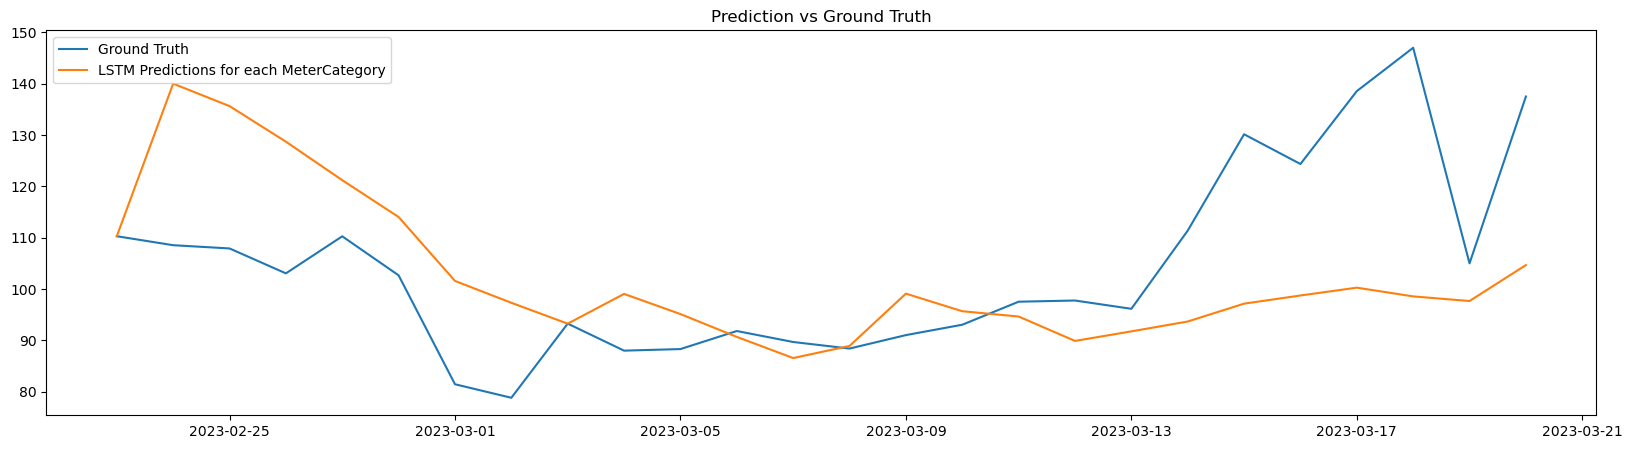

MDA = 0.52
RMSE = 18.287248282182446


In [69]:
pred_data = Compare_df['predictions']
truth_data = Compare_df['Ground_truth']

# Create the plot
plt.figure(figsize=(20, 5))
plt.plot(truth_data, label="Ground Truth")
plt.plot(pred_data, label="LSTM Predictions for each MeterCategory")

# Add title and legends
plt.title("Prediction vs Ground Truth")
plt.legend()

# Display the plot
plt.show()

print("MDA =",da(truth_data,pred_data))
print("RMSE =",RMSE_TEST[7])